In [1]:
from moded_eval import YOLACTConfig, Yolact, evalimage, prep_display, FastBaseTransform, evaluate
from torch import no_grad, from_numpy
from utils.functions import SavePath
import matplotlib.pyplot as plt
from cv2 import imread
from data import cfg, set_cfg
from numpy import array



KeyboardInterrupt: 

In [3]:
# MODEL_NAME = "yolact_darknet53_54_800000"
MODEL_NAME = "yolact_resnet50_54_800000"

args = YOLACTConfig(top_k=15, score_threshold=0.15)
args.trained_model = "weights/" + MODEL_NAME +".pth"
model_path = SavePath.from_str(args.trained_model)
args.config = model_path.model_name + '_config'
cfg.mask_proto_debug = args.mask_proto_debug
set_cfg(args.config)

In [4]:

net = Yolact()
net.detect.use_fast_nms = args.fast_nms
net.load_weights(args.trained_model)
net.eval()


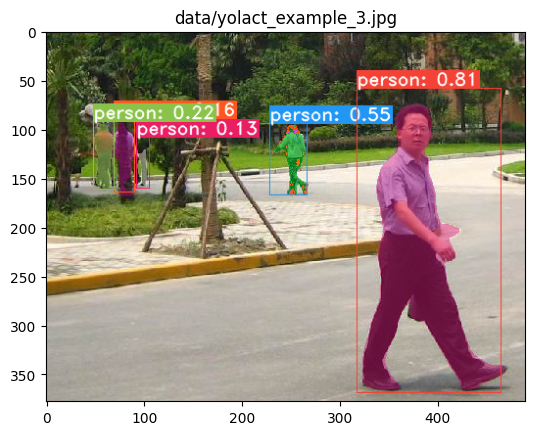

In [5]:
args.image="data/yolact_example_3.jpg"
# The evaluate function should always be run 
# it intializes the args in the moded_eval file for the other functinos to work to work
with no_grad():
    # evaluate(net, dataset=None)
    evalimage(net, args.image)

## Convert Model Into Onnx Format

In [6]:
from os import path, makedirs
from torch.onnx import export
MODELS_PATH = "models"
if not path.exists(f"{MODELS_PATH}"):
    makedirs(MODELS_PATH)

if path.exists(f"{MODELS_PATH}"):
    net.eval()
    input_names = [ "actual_input" ]
    output_names = [ "output" ]
    frame = from_numpy(imread(args.image)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)
    onnx_model_path = f"{MODELS_PATH}/{MODEL_NAME}.onnx"
    export(net, batch, onnx_model_path, input_names=input_names, output_names=output_names, export_params=True)

c:\Users\Terep\Desktop\Learning\238-yolact-image-segmentation-demo-using-openvino-and-onnx\yolact.py:254: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.last_conv_size != (conv_w, conv_h):
c:\Users\Terep\Desktop\Learning\238-yolact-image-segmentation-demo-using-openvino-and-onnx\layers\functions\detection.py:99: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if scores.size(1) == 0:
c:\Users\Terep\Desktop\Learning\ov_venv\lib\site-packages\torch\onnx\symbolic_opset9.py:5535: UserWarning: Exporting aten::index operator with indices of type Byte. On

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [7]:
# to use the onnx module for inference you'd have to install  onnxruntime  
# !pip install onnxruntime
# from onnxruntime import InferenceSession
# onnx_session= InferenceSession(onnx_model_path)
# onnx_inputs= onnx_session.get_inputs()[0].name
# onnx_labels= onnx_session.get_outputs()[0].name


In [8]:
# a function to add the original classes that were in the pytorch model output
# it also converts the output to the same format to be able to use the same functions on the output
# def add_labels_for_onnx(preds):
#     converted_preds = [{'box':preds[0], 'mask':preds[1], 'class':preds[2], 'score':preds[3], 'proto':preds[4]}]
#     for key, values in converted_preds[0].items():
#         converted_preds[0][key] = from_numpy(array(values))
#     return converted_preds


In [9]:
# def eval_onnx_image(path):
#     with no_grad():
#         frame = from_numpy(imread(path)).float()
#         batch = FastBaseTransform()(frame.unsqueeze(0))
#         onnx_preds = onnx_session.run(None, {onnx_inputs:batch.detach().numpy()})
#         onnx_preds = add_labels_for_onnx(onnx_preds)
#         img_numpy = prep_display(onnx_preds, frame, None, None, undo_transform=False)
#         img_numpy = img_numpy[:, :, (2, 1, 0)]
#         plt.imshow(img_numpy)
#         plt.title(path)
#         plt.show()

# eval_onnx_image(args.image)

## Convert the model to the IR:

In [10]:
# !mo  --input_model models/Yolact_Model.onnx 
from openvino.tools.mo import convert_model
ov_model = convert_model(input_model=onnx_model_path)

## Load The Model

In [11]:
from openvino.runtime import Core
ie = Core()
compiled_model = ie.compile_model(model=ov_model)
output_layer_ir = compiled_model.output(0)

## Save the model into disk

In [12]:
# from openvino.runtime import serialize
# serialize(ov_model, xml_path=f"{MODELS_PATH}/{MODEL_NAME}.xml", bin_path=f"{MODELS_PATH}/{MODEL_NAME}.bin")

## Read and Compile model from disk

In [13]:
# from openvino.runtime import Core
# ie = Core()
# model = ie.read_model(model=f"models/{MODEL_NAME}.xml")
# compiled_model = ie.compile_model(model)


In [14]:
# a function to add the original classes that were in the pytorch model output
# it also converts the output to the same format to be able to use the same functions on the output
def add_labels_for_openvino(preds):
    keys = list(preds.keys())
    converted_preds = [{'box':preds[keys[0]], 'mask':preds[keys[1]], 'class':preds[keys[2]], 'score':preds[keys[3]], 'proto':preds[keys[4]]}]
    for dict_key, values in converted_preds[0].items():
        converted_preds[0][dict_key] = from_numpy(array(values))
    return converted_preds

In [15]:
def openvino_eval_image(path):
    with no_grad():
        frame = from_numpy(imread(path)).float()
        batch = FastBaseTransform()(frame.unsqueeze(0))
        openvino_preds = compiled_model([batch.detach().numpy()])
        openvino_preds = add_labels_for_openvino(openvino_preds)
        img_numpy = prep_display(openvino_preds, frame, None, None, undo_transform=False)
        img_numpy = img_numpy[:, :, (2, 1, 0)]
        plt.imshow(img_numpy)
        plt.title(path)
        plt.show()

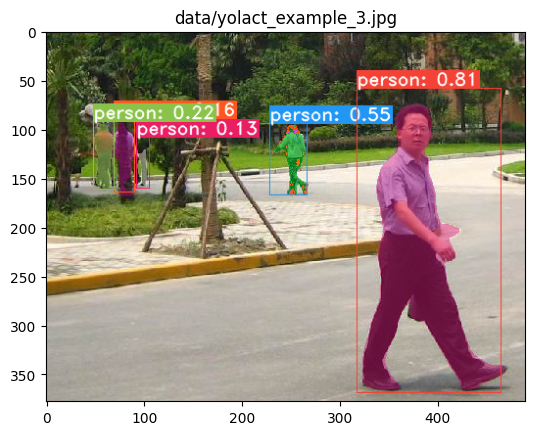

In [16]:
openvino_eval_image(args.image)